In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)
import plaidml.keras
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
plaidml.keras.install_backend()
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [2]:

df = pd.read_excel("../data/Abbottabad/dust.xlsx")
df = df[['Sensor Value']]
df

,Sensor Value
0,0.10
1,0.10
2,0.10
3,0.10
4,0.10
...,...
1238,0.12
1239,0.12
1240,0.12
1241,0.13


In [3]:
Days = pd.date_range(start="2017-09-07",end="2020-06-25")

In [4]:
dataframe = pd.DataFrame()
dataframe['ds'] = Days
dataframe['ds'] = dataframe['ds'].dt.date
dataframe['y'] = df[['Sensor Value']]
dataframe

,ds,y
0,2017-09-07,0.10
1,2017-09-08,0.10
2,2017-09-09,0.10
3,2017-09-10,0.10
4,2017-09-11,0.10
...,...,...
1018,2020-06-21,0.14
1019,2020-06-22,0.12
1020,2020-06-23,0.13
1021,2020-06-24,0.17


In [5]:

dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      1023 non-null   object 
 1   y       1023 non-null   float64
dtypes: float64(1), object(1)
memory usage: 16.1+ KB


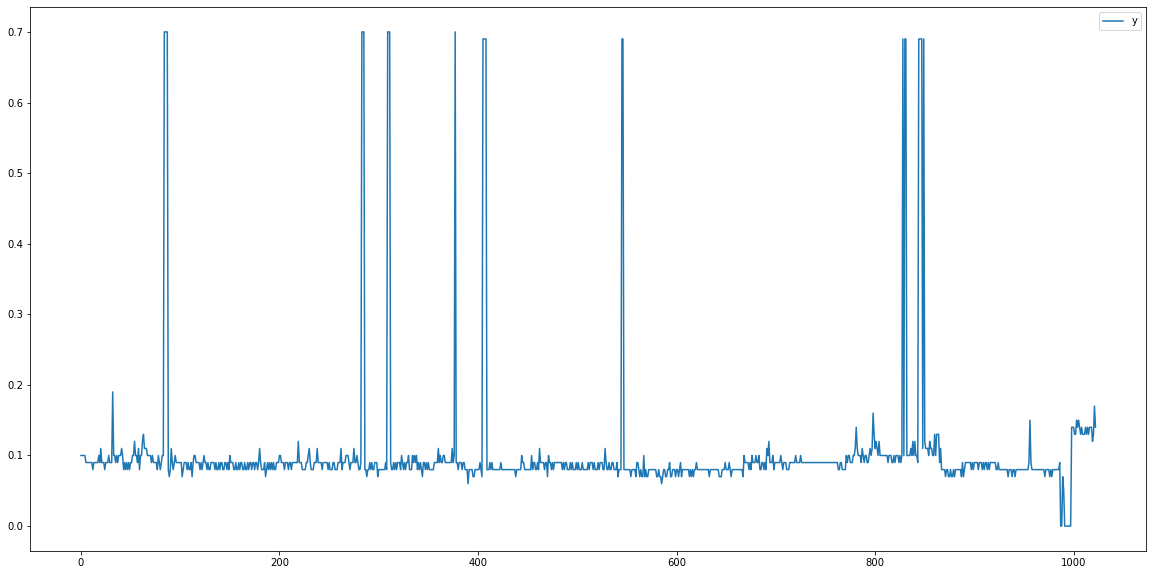

In [6]:
dataframe.plot()

In [7]:
df1=dataframe.reset_index()['y']

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [9]:
df1

array([[0.14285714],
       [0.14285714],
       [0.14285714],
       ...,
       [0.18571429],
       [0.24285714],
       [0.2       ]])

In [10]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.70)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [11]:
training_size,test_size

(716, 307)

In [12]:
train_data

array([[0.14285714],
       [0.14285714],
       [0.14285714],
       [0.14285714],
       [0.14285714],
       [0.12857143],
       [0.12857143],
       [0.12857143],
       [0.12857143],
       [0.12857143],
       [0.12857143],
       [0.12857143],
       [0.11428571],
       [0.12857143],
       [0.12857143],
       [0.12857143],
       [0.12857143],
       [0.12857143],
       [0.14285714],
       [0.12857143],
       [0.15714286],
       [0.12857143],
       [0.12857143],
       [0.12857143],
       [0.11428571],
       [0.12857143],
       [0.12857143],
       [0.12857143],
       [0.14285714],
       [0.12857143],
       [0.12857143],
       [0.12857143],
       [0.27142857],
       [0.14285714],
       [0.14285714],
       [0.12857143],
       [0.14285714],
       [0.12857143],
       [0.14285714],
       [0.14285714],
       [0.14285714],
       [0.15714286],
       [0.14285714],
       [0.11428571],
       [0.12857143],
       [0.11428571],
       [0.12857143],
       [0.114

In [13]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [14]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 6
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [15]:
print(X_train.shape), print(y_train.shape)

(709, 6)
(709,)


(None, None)

In [16]:
print(X_test.shape), print(ytest.shape)

(300, 6)
(300,)


(None, None)

In [17]:

# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [18]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 50)             20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=len(X_train)-1,verbose=1)


Epoch 1/200
2/2 [==============================] - 6s 1s/step - loss: 0.0404 - val_loss: 0.0378
Epoch 2/200
2/2 [==============================] - 0s 69ms/step - loss: 0.0330 - val_loss: 0.0310
Epoch 3/200
2/2 [==============================] - 0s 69ms/step - loss: 0.0270 - val_loss: 0.0251
Epoch 4/200
2/2 [==============================] - 0s 66ms/step - loss: 0.0220 - val_loss: 0.0208
Epoch 5/200
2/2 [==============================] - 0s 64ms/step - loss: 0.0186 - val_loss: 0.0193
Epoch 6/200
2/2 [==============================] - 0s 77ms/step - loss: 0.0181 - val_loss: 0.0200
Epoch 7/200
2/2 [==============================] - 0s 66ms/step - loss: 0.0194 - val_loss: 0.0200
Epoch 8/200
2/2 [==============================] - 0s 72ms/step - loss: 0.0193 - val_loss: 0.0194
Epoch 9/200
2/2 [==============================] - 0s 68ms/step - loss: 0.0184 - val_loss: 0.0193
Epoch 10/200
2/2 [==============================] - 0s 67ms/step - loss: 0.0179 - val_loss: 0.0199
Epoch 11/200
2/2 [===

2/2 [==============================] - 0s 65ms/step - loss: 0.0177 - val_loss: 0.0195
Epoch 84/200
2/2 [==============================] - 0s 64ms/step - loss: 0.0177 - val_loss: 0.0195
Epoch 85/200
2/2 [==============================] - 0s 61ms/step - loss: 0.0177 - val_loss: 0.0194
Epoch 86/200
2/2 [==============================] - 0s 63ms/step - loss: 0.0177 - val_loss: 0.0194
Epoch 87/200
2/2 [==============================] - 0s 63ms/step - loss: 0.0177 - val_loss: 0.0194
Epoch 88/200
2/2 [==============================] - 0s 64ms/step - loss: 0.0177 - val_loss: 0.0194
Epoch 89/200
2/2 [==============================] - 0s 65ms/step - loss: 0.0177 - val_loss: 0.0194
Epoch 90/200
2/2 [==============================] - 0s 61ms/step - loss: 0.0177 - val_loss: 0.0194
Epoch 91/200
2/2 [==============================] - 0s 67ms/step - loss: 0.0177 - val_loss: 0.0194
Epoch 92/200
2/2 [==============================] - 0s 63ms/step - loss: 0.0177 - val_loss: 0.0193
Epoch 93/200
2/2 [=====

2/2 [==============================] - 0s 65ms/step - loss: 0.0163 - val_loss: 0.0171
Epoch 166/200
2/2 [==============================] - 0s 60ms/step - loss: 0.0161 - val_loss: 0.0168
Epoch 167/200
2/2 [==============================] - 0s 60ms/step - loss: 0.0160 - val_loss: 0.0166
Epoch 168/200
2/2 [==============================] - 0s 62ms/step - loss: 0.0159 - val_loss: 0.0164
Epoch 169/200
2/2 [==============================] - 0s 74ms/step - loss: 0.0158 - val_loss: 0.0164
Epoch 170/200
2/2 [==============================] - 0s 62ms/step - loss: 0.0157 - val_loss: 0.0166
Epoch 171/200
2/2 [==============================] - 0s 63ms/step - loss: 0.0157 - val_loss: 0.0169
Epoch 172/200
2/2 [==============================] - 0s 61ms/step - loss: 0.0158 - val_loss: 0.0172
Epoch 173/200
2/2 [==============================] - 0s 64ms/step - loss: 0.0159 - val_loss: 0.0167
Epoch 174/200
2/2 [==============================] - 0s 64ms/step - loss: 0.0157 - val_loss: 0.0161
Epoch 175/200


In [21]:
### Lets Do the prediction and check performance metrics
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error

test_predict=model.predict(X_test)
test_predict=scaler.inverse_transform(test_predict)
mse = mean_squared_error(ytest,test_predict)
mse

0.021855319085359034

In [22]:
len(test_data)

307

In [23]:
x_input=test_data[0:time_step].reshape(1,-1)
x_input.shape

(1, 6)

In [24]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [25]:
temp_input

[0.12857142857142856,
 0.12857142857142856,
 0.12857142857142856,
 0.12857142857142856,
 0.14285714285714288,
 0.12857142857142856]

In [26]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=time_step
i=0
while(i<7):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.14012527]
7
1 day input [0.12857143 0.12857143 0.12857143 0.14285714 0.12857143 0.14012527]
1 day output [[0.14031883]]
2 day input [0.12857143 0.12857143 0.14285714 0.12857143 0.14012527 0.14031883]
2 day output [[0.14049014]]
3 day input [0.12857143 0.14285714 0.12857143 0.14012527 0.14031883 0.14049014]
3 day output [[0.1404672]]
4 day input [0.14285714 0.12857143 0.14012527 0.14031883 0.14049014 0.1404672 ]
4 day output [[0.14028609]]
5 day input [0.12857143 0.14012527 0.14031883 0.14049014 0.1404672  0.14028609]
5 day output [[0.1403372]]
6 day input [0.14012527 0.14031883 0.14049014 0.1404672  0.14028609 0.1403372 ]
6 day output [[0.14002085]]
[[0.14012527465820312], [0.14031882584095], [0.14049014449119568], [0.14046719670295715], [0.14028608798980713], [0.14033719897270203], [0.14002084732055664]]


In [27]:
final_pred = scaler.inverse_transform(lst_output)
final_pred

array([[0.09808769],
       [0.09822318],
       [0.0983431 ],
       [0.09832704],
       [0.09820026],
       [0.09823604],
       [0.09801459]])

In [28]:
forecasting={
    
    'Day-1':final_pred[0][0],
    'Day-2':final_pred[1][0],
    'Day-3':final_pred[2][0],
    'Day-4':final_pred[3][0],
    'Day-5':final_pred[4][0],
    'Day-6':final_pred[5][0],
    'Day-7':final_pred[6][0],
    'MSE': mse
}

In [29]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import db
cred = credentials.Certificate("../config/sensors-forecasting-fc27d-firebase-adminsdk-krgvi-403182645e.json")
firebase_admin.initialize_app(cred,{'databaseURL':'https://sensors-forecasting-fc27d-default-rtdb.firebaseio.com/'})
ref = db.reference("/Models/LSTM")
upload_ref = ref.child('Dust')
upload_ref.update(forecasting)